In [1]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals
try:
    %tensorflow_version 2.x
except Exception:
    pass
import tensorflow as tf
from keras.models import Model
from keras.layers import Input, Dense, LSTM, Bidirectional
from keras import backend as K
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import datetime
import os

generation_data = pd.read_csv('/content/gdrive/My Drive/capstone1/generation.csv')
generation_data.head()
weather_data = pd.read_csv('/content/gdrive/My Drive/capstone1/weather.csv')
weather_data.head()

datetime  temperature  precipitation  ...  humidity  sunlight  generation
0  2017/01/01 1:00          5.0            NaN  ...      93.0       NaN         NaN
1  2017/01/01 2:00          4.1            NaN  ...      93.0       NaN         NaN
2  2017/01/01 3:00          3.3            NaN  ...      94.0       NaN         NaN
3  2017/01/01 4:00          2.5            NaN  ...      95.0       NaN         NaN
4  2017/01/01 5:00          2.1            NaN  ...      97.0       NaN         NaN

[5 rows x 7 columns]

In [3]:
def merge_data(g_data, w_data):
    temp_data = w_data
    for index in g_data.index:
        for hour in range(0, 24):
            temp_data.iloc[index*24 + hour, 6] = g_data.iloc[index, hour+2]
    return temp_data.fillna(0)

In [4]:
transformed_data = merge_data(generation_data, weather_data)

In [ ]:
# transformed_data.to_csv('/content/gdrive/My Drive/capstone1/transformed_data.csv', mode='w')

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f4632d2f208>,
      dtype=object)

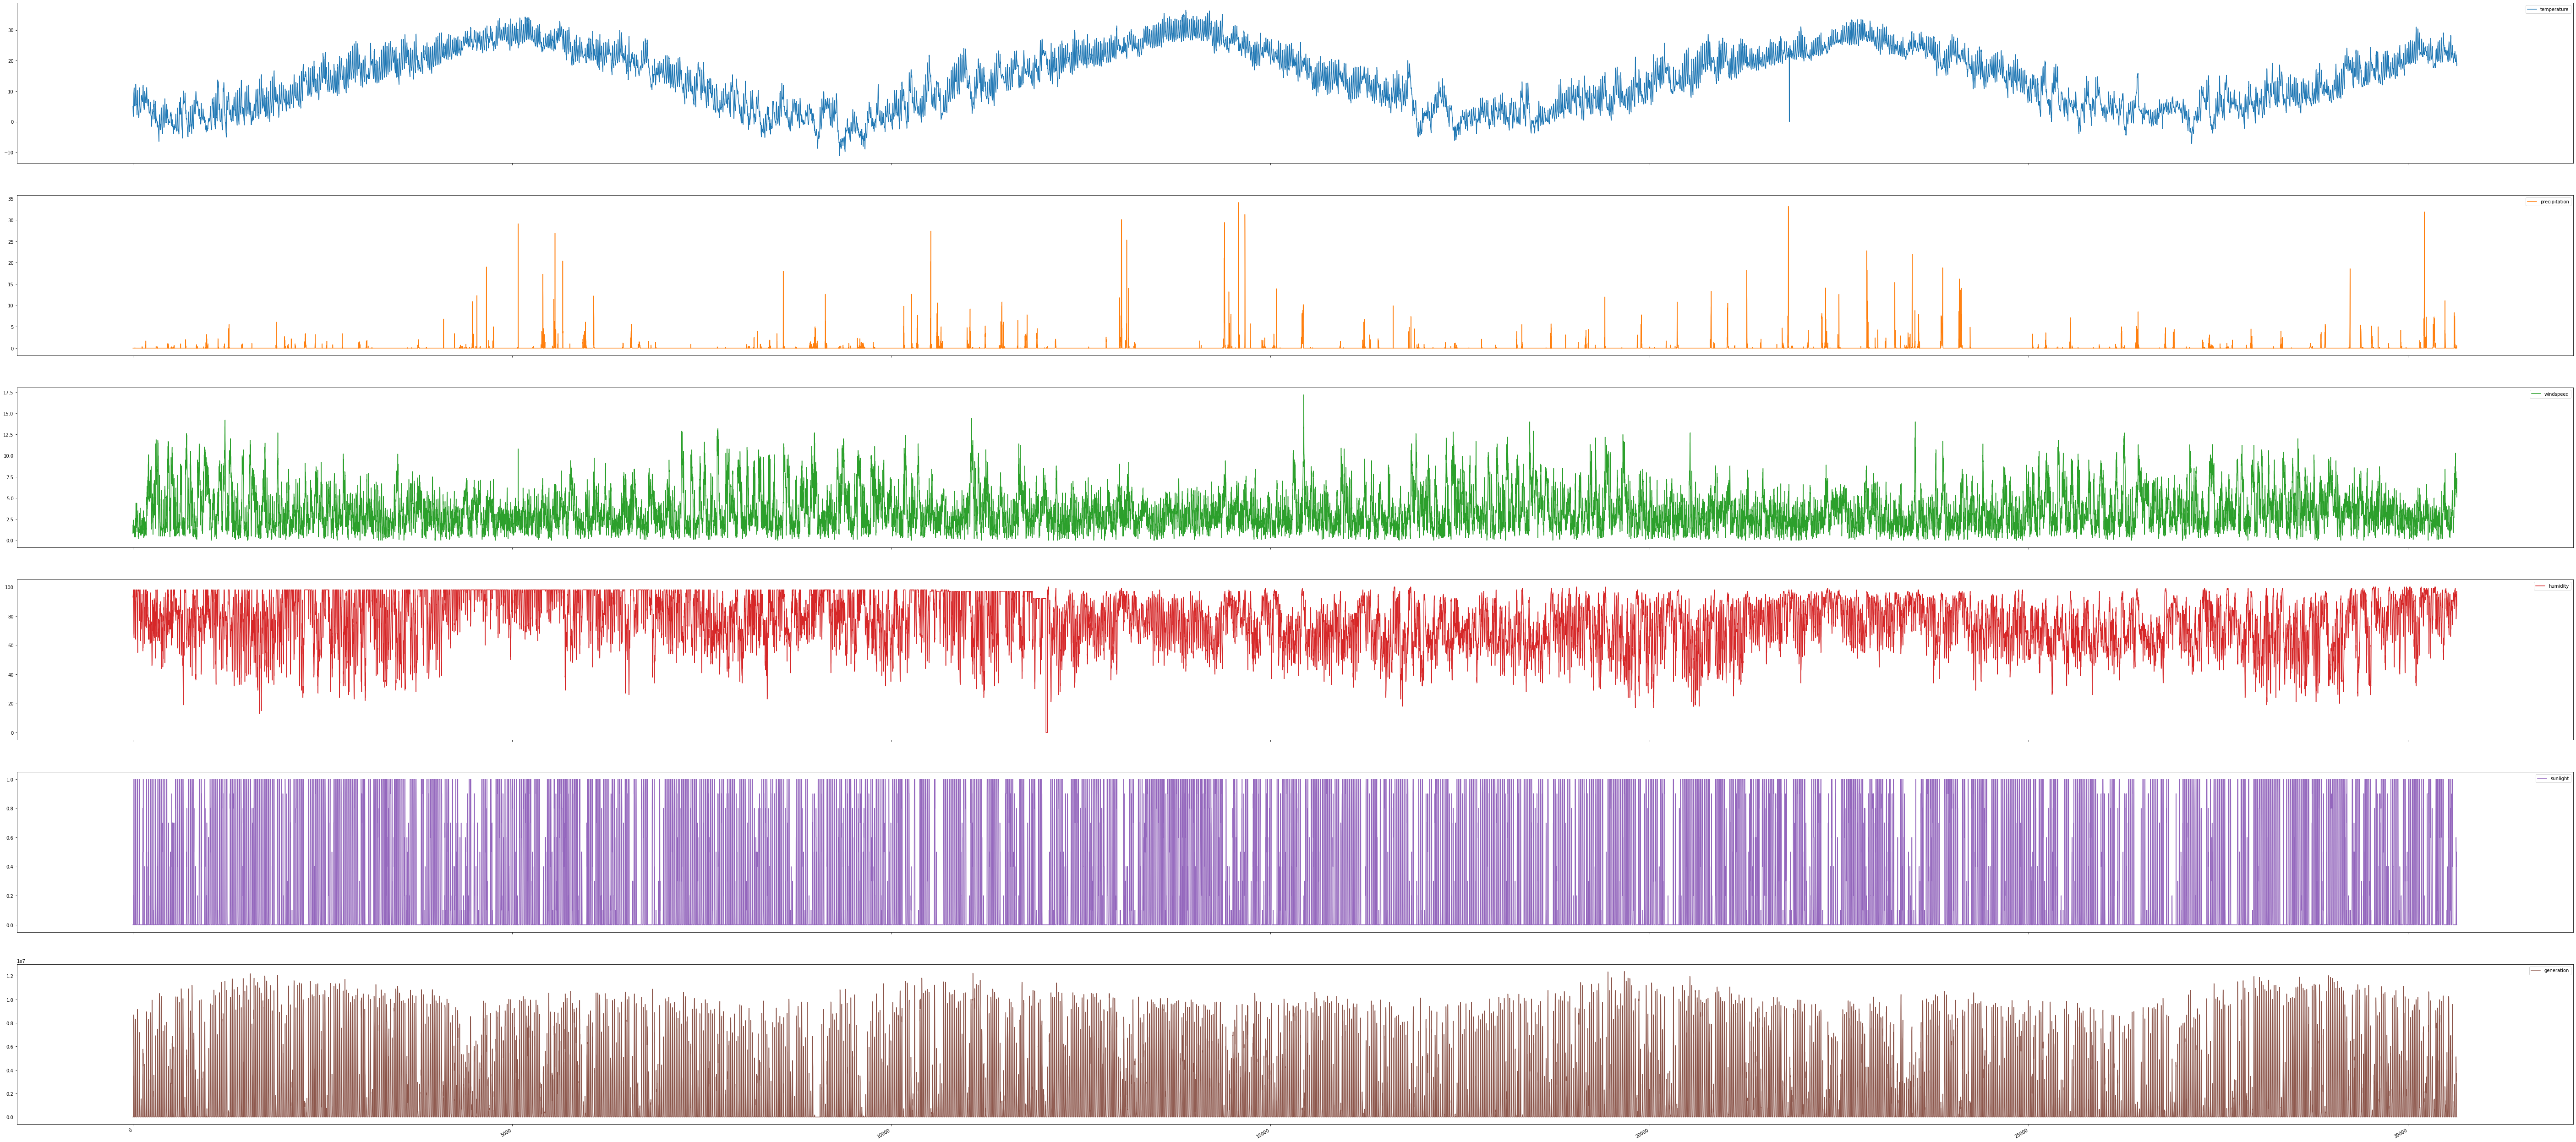

In [5]:
transformed_data.plot(subplots=True, figsize=(100,50))

In [6]:
features = ['temperature', 'precipitation', 'windspeed', 'humidity', 'sunlight', 'generation']
features = transformed_data[features]
features.index = transformed_data['datetime']
features.head()

temperature  precipitation  ...  sunlight  generation
datetime                                     ...                      
2017/01/01 1:00          5.0            0.0  ...       0.0         0.0
2017/01/01 2:00          4.1            0.0  ...       0.0         0.0
2017/01/01 3:00          3.3            0.0  ...       0.0         0.0
2017/01/01 4:00          2.5            0.0  ...       0.0         0.0
2017/01/01 5:00          2.1            0.0  ...       0.0         0.0

[5 rows x 6 columns]

In [7]:
train_size = int(len(transformed_data) * 0.7)
tf.random.set_seed(30)

dataset = features.values
data_mean = dataset[:train_size].mean(axis=0)
data_std = dataset[:train_size].std(axis=0)
dataset = (dataset - data_mean)/data_std

In [8]:
def multivariate_data(dataset, target, start_index, end_index, history_size, 
                      target_size, step, single_step=False):
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size

    for i in range(start_index, end_index):
        indices = range(i-history_size, i, step)
        data.append(dataset[indices])
        if single_step:
            labels.append(target[i+target_size])
        else:
            labels.append(target[i:i+target_size])
    return np.array(data, dtype=np.float), np.array(labels, dtype=np.float)

In [10]:
def create_time_steps(length):
    return list(range(-length, 0))

def show_plot(plot_data, delta, title):
    labels = ['history', 'true future', 'model prediction']
    marker = ['.-', 'rx', 'go']
    time_steps = create_time_steps(plot_data[0].shape[0])
    if delta:
        future = delta
    else:
        future = 0

    plt.title(title)
    for i, x in enumerate(plot_data):
        if i:
            plt.plot(future, plot_data[i], marker[i], markersize=10, label=labels[i])
        else:
            plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
    plt.legend()
    plt.xlim([time_steps[0], (future+5)*2])
    plt.xlabel('Time-step')
    return plt

In [11]:
def multi_step_plot(history, true_future, prediction):
    plt.figure(figsize=(12,6))
    num_in = create_time_steps(len(history))
    num_out = len(true_future)
    plt.plot(num_in, np.array(history[:, 5]), label='history')
    plt.plot(np.arange(num_out)/STEP, np.array(true_future), 'b', label='true future')
    if prediction.any():
        plt.plot(np.arange(num_out)/STEP, np.array(prediction), 'r', label='predicted future')
    plt.legend(loc='upper left')
    plt.show()

In [12]:
def plot_train_history(history, title):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(loss))
    plt.figure()
    plt.plot(epochs, loss, 'b', label='train_loss')
    plt.plot(epochs, val_loss, 'r', label='val_loss')
    plt.title(title)
    plt.legend()
    plt.show

In [13]:
past_history = 720
future_target = 24
STEP = 1

x_train_multi, y_train_multi = multivariate_data(dataset, dataset[:, 5], 0, 
                                                   train_size, past_history, 
                                                   future_target, STEP)
x_val_multi, y_val_multi = multivariate_data(dataset, dataset[:, 5], 
                                               train_size, None, past_history, 
                                               future_target, STEP)

In [14]:
print('single window of past history')
print(x_train_multi.shape)

single window of past history
(20733, 720, 6)


In [15]:
batch_size = 64
buffer_size = 10000

train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))
train_data_multi = train_data_multi.cache().shuffle(buffer_size).batch(batch_size).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_data_multi = val_data_multi.batch(batch_size).repeat()

In [16]:
print(tf.test.gpu_device_name())

/device:GPU:0


In [17]:
with tf.device('/device:GPU:0'):
    multi_step_model = tf.keras.models.Sequential()
    multi_step_model.add(tf.keras.layers.LSTM(32, return_sequences=True, 
                                              input_shape=x_train_multi.shape[-2:]))
    # multi_step_model.add(tf.keras.layers.LSTM(64, return_sequences=True))
    # multi_step_model.add(tf.keras.layers.LSTM(128, return_sequences=True))
    multi_step_model.add(tf.keras.layers.LSTM(16))
    multi_step_model.add(tf.keras.layers.Dense(24))

    multi_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(clipvalue=1.0), loss='mae')
    
    callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)

In [18]:
multi_step_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 720, 32)           4992      
_________________________________________________________________
lstm_1 (LSTM)                (None, 16)                3136      
_________________________________________________________________
dense (Dense)                (None, 24)                408       
Total params: 8,536
Trainable params: 8,536
Non-trainable params: 0
_________________________________________________________________


In [ ]:
evaluation_interval = 10

multi_step_history = multi_step_model.fit(train_data_multi, epochs=300,
                                          steps_per_epoch=evaluation_interval,
                                          validation_data=val_data_multi,
                                          validation_steps=50,
                                          callbacks=[callback])

Epoch 1/300
10/10 [==============================] - 2s 229ms/step - loss: 0.8001 - val_loss: 0.7243
Epoch 2/300
10/10 [==============================] - 2s 177ms/step - loss: 0.7402 - val_loss: 0.6659
Epoch 3/300
10/10 [==============================] - 2s 173ms/step - loss: 0.6905 - val_loss: 0.6130
Epoch 4/300
10/10 [==============================] - 2s 185ms/step - loss: 0.6145 - val_loss: 0.5680
Epoch 5/300
10/10 [==============================] - 2s 179ms/step - loss: 0.5953 - val_loss: 0.5268
Epoch 6/300
10/10 [==============================] - 2s 182ms/step - loss: 0.5663 - val_loss: 0.4988
Epoch 7/300
10/10 [==============================] - 2s 180ms/step - loss: 0.5608 - val_loss: 0.4760
Epoch 8/300
10/10 [==============================] - 2s 183ms/step - loss: 0.5238 - val_loss: 0.4562
Epoch 9/300
10/10 [==============================] - 2s 173ms/step - loss: 0.5035 - val_loss: 0.4421
Epoch 10/300
10/10 [==============================] - 2s 179ms/step - loss: 0.4865 - val_lo

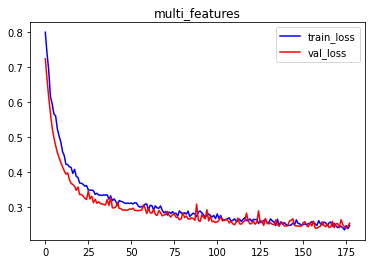

In [ ]:
plot_train_history(multi_step_history, 'multi_features')

(720, 6) (64, 24) (64, 24)


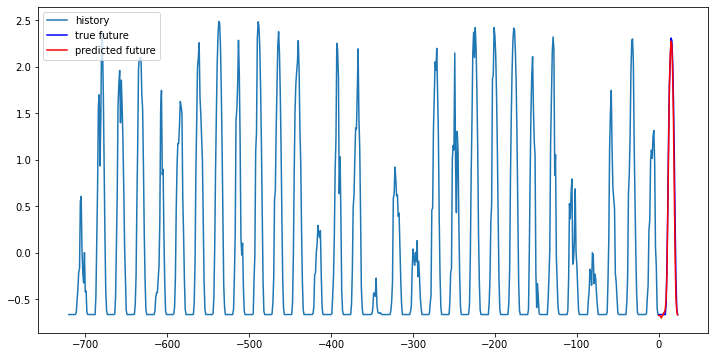

(720, 6) (64, 24) (64, 24)


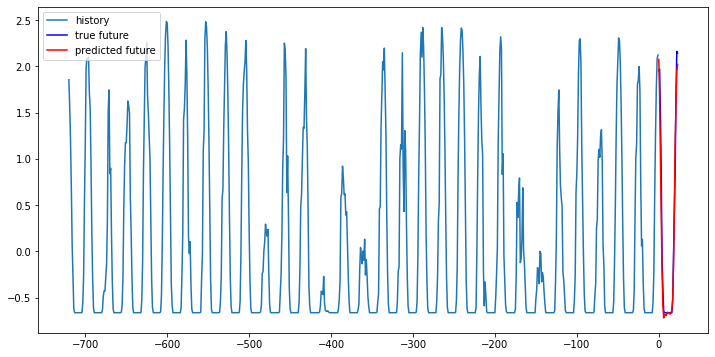

(720, 6) (64, 24) (64, 24)


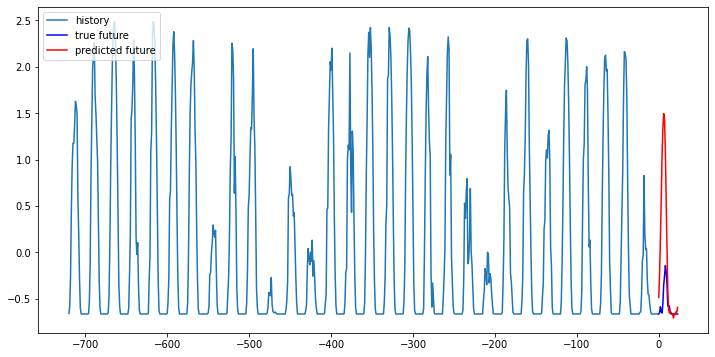

(720, 6) (64, 24) (64, 24)


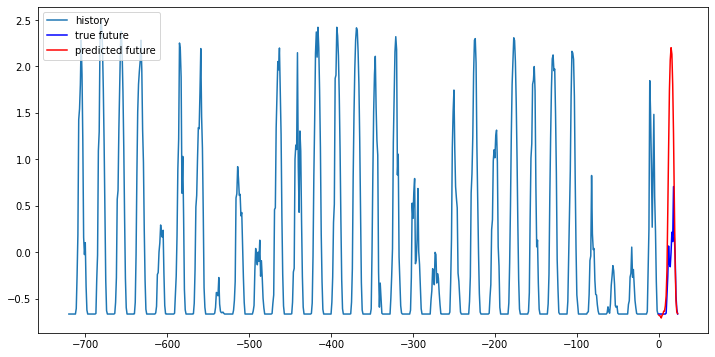

(720, 6) (64, 24) (64, 24)


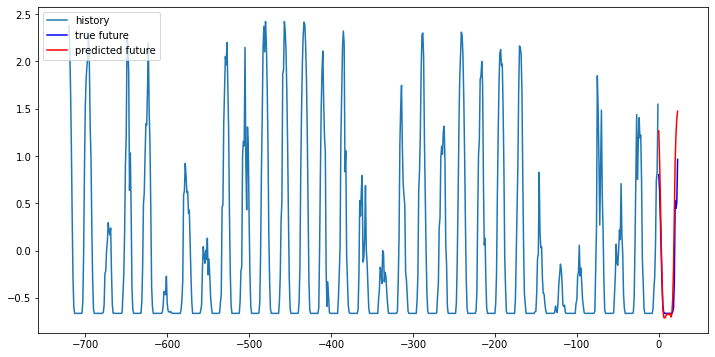

(720, 6) (64, 24) (64, 24)


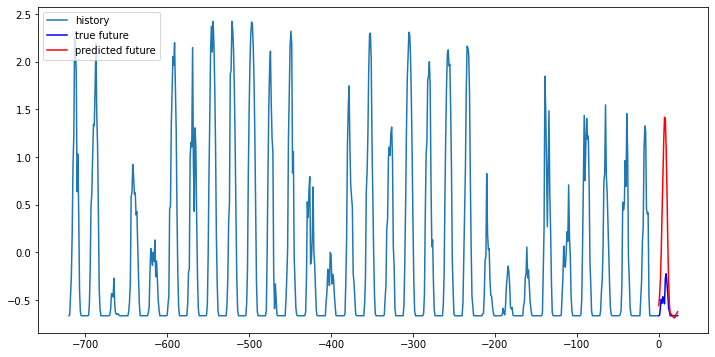

(720, 6) (64, 24) (64, 24)


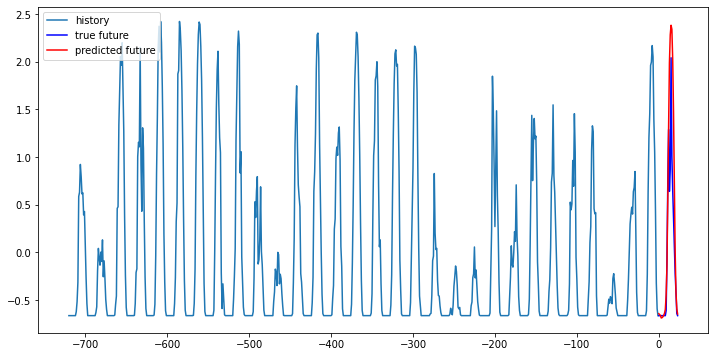

(720, 6) (64, 24) (64, 24)


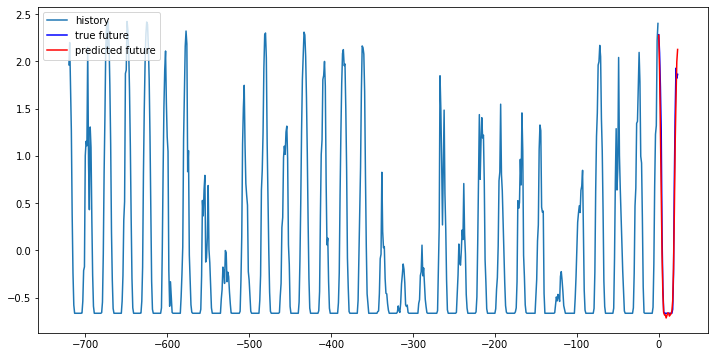

(720, 6) (64, 24) (64, 24)


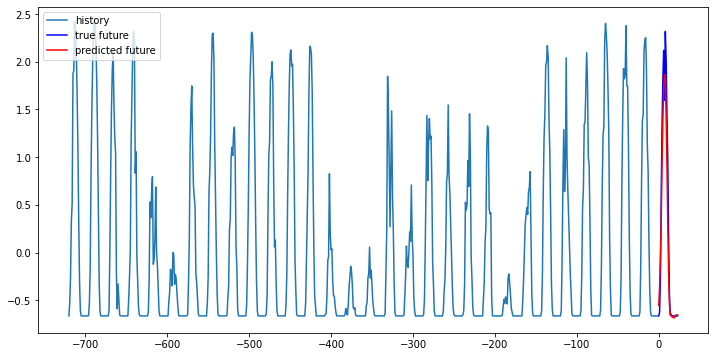

(720, 6) (64, 24) (64, 24)


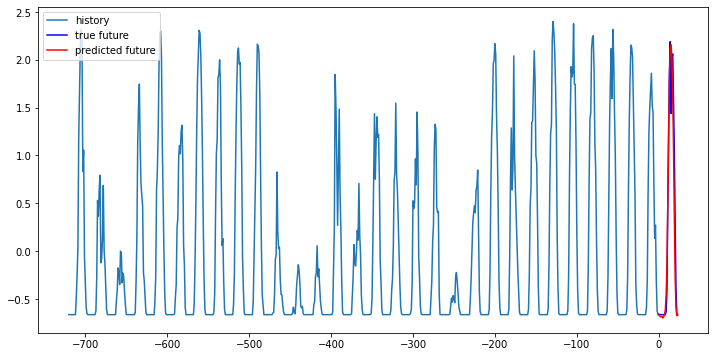

(720, 6) (64, 24) (64, 24)


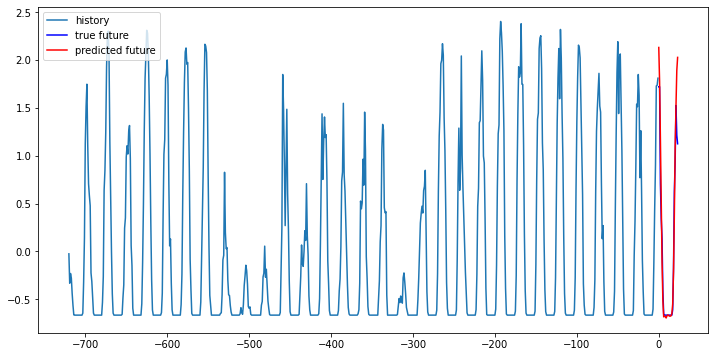

(720, 6) (64, 24) (64, 24)


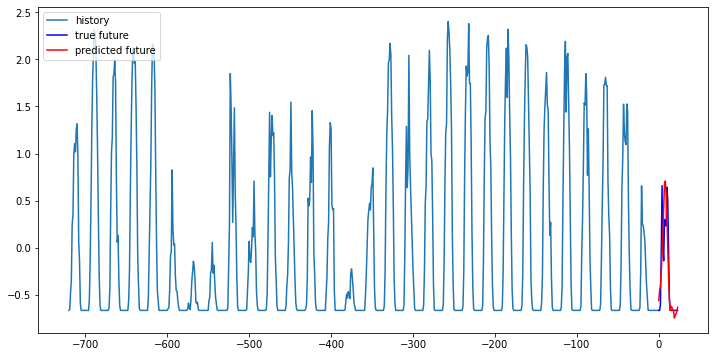

(720, 6) (64, 24) (64, 24)


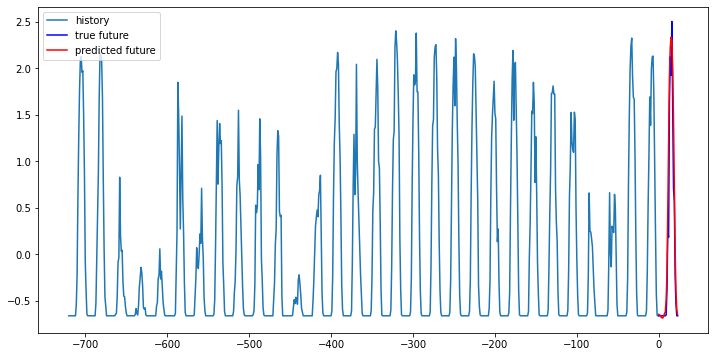

(720, 6) (64, 24) (64, 24)


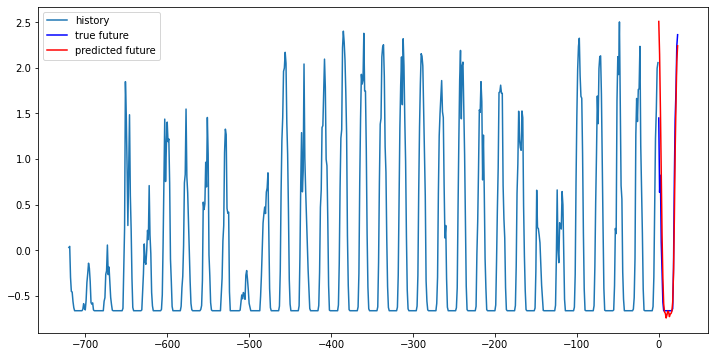

(720, 6) (64, 24) (64, 24)


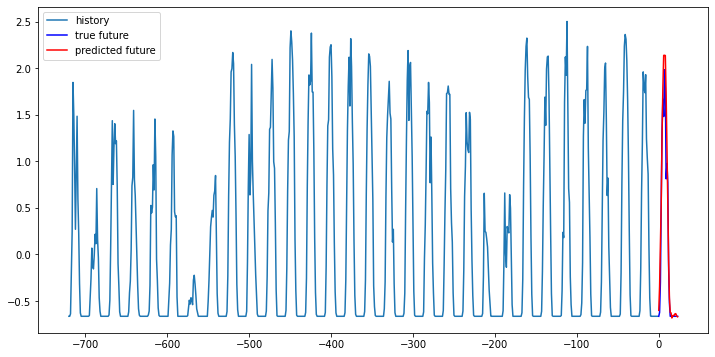

(720, 6) (64, 24) (64, 24)


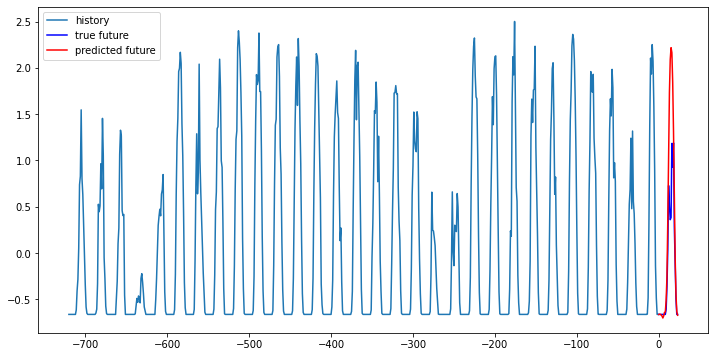

(720, 6) (64, 24) (64, 24)


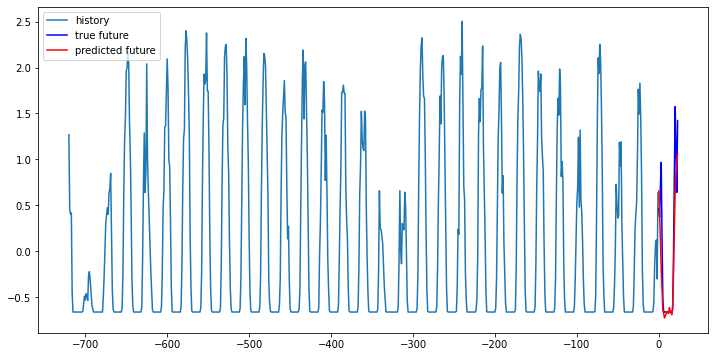

(720, 6) (64, 24) (64, 24)


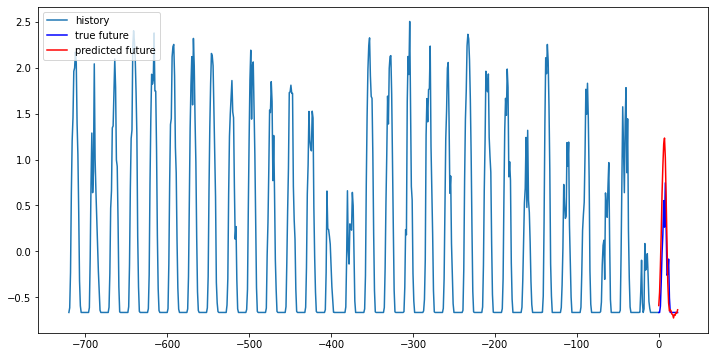

(720, 6) (64, 24) (64, 24)


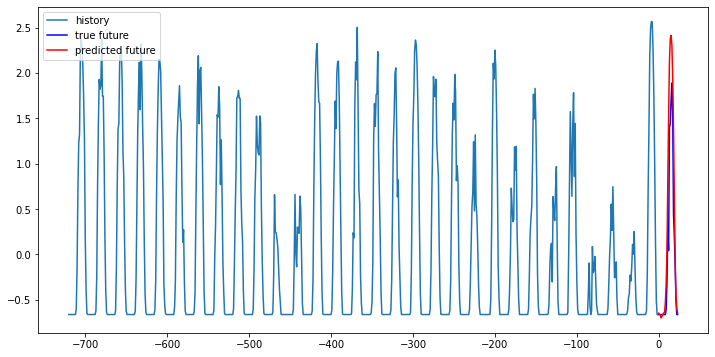

(720, 6) (64, 24) (64, 24)


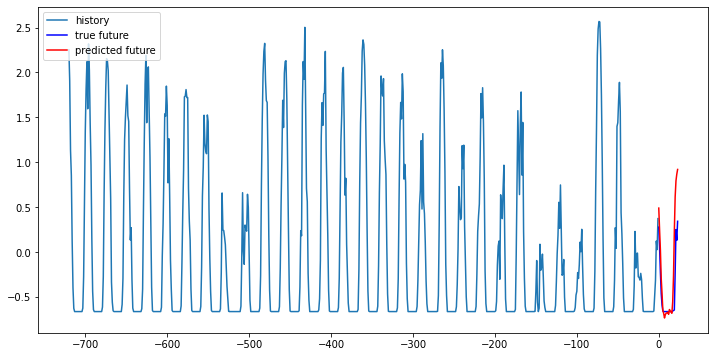

In [ ]:
for x, y in val_data_multi.take(20):
    print(x[0].shape, y.shape, multi_step_model.predict(x).shape)
    multi_step_plot(x[0], y[0], multi_step_model.predict(x)[0])


In [ ]:
def univariate_data(dataset, start_index, end_index, history_size, target_size):
    data = []
    labels = []
    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size
    for i in range(start_index, end_index):
        indices = range(i - history_size, i)
        data.append(np.reshape(dataset[indices], (history_size, 1)))
        labels.append(dataset[i+target_size])
    return np.array(data, dtype=np.float), np.array(labels, dtype=np.float)

In [43]:
uni_data = transformed_data['generation']
uni_data.index = transformed_data['datetime']
# for index in uni_data.index:
#     if int(index[-5:-3]) in [0,1,2,3,4,5,21,22,23]:
#         uni_data = uni_data.drop(index)
uni_data.head()

datetime
2017/01/01 1:00    0.0
2017/01/01 2:00    0.0
2017/01/01 3:00    0.0
2017/01/01 4:00    0.0
2017/01/01 5:00    0.0
Name: generation, dtype: float64

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f46675e4278>],
      dtype=object)

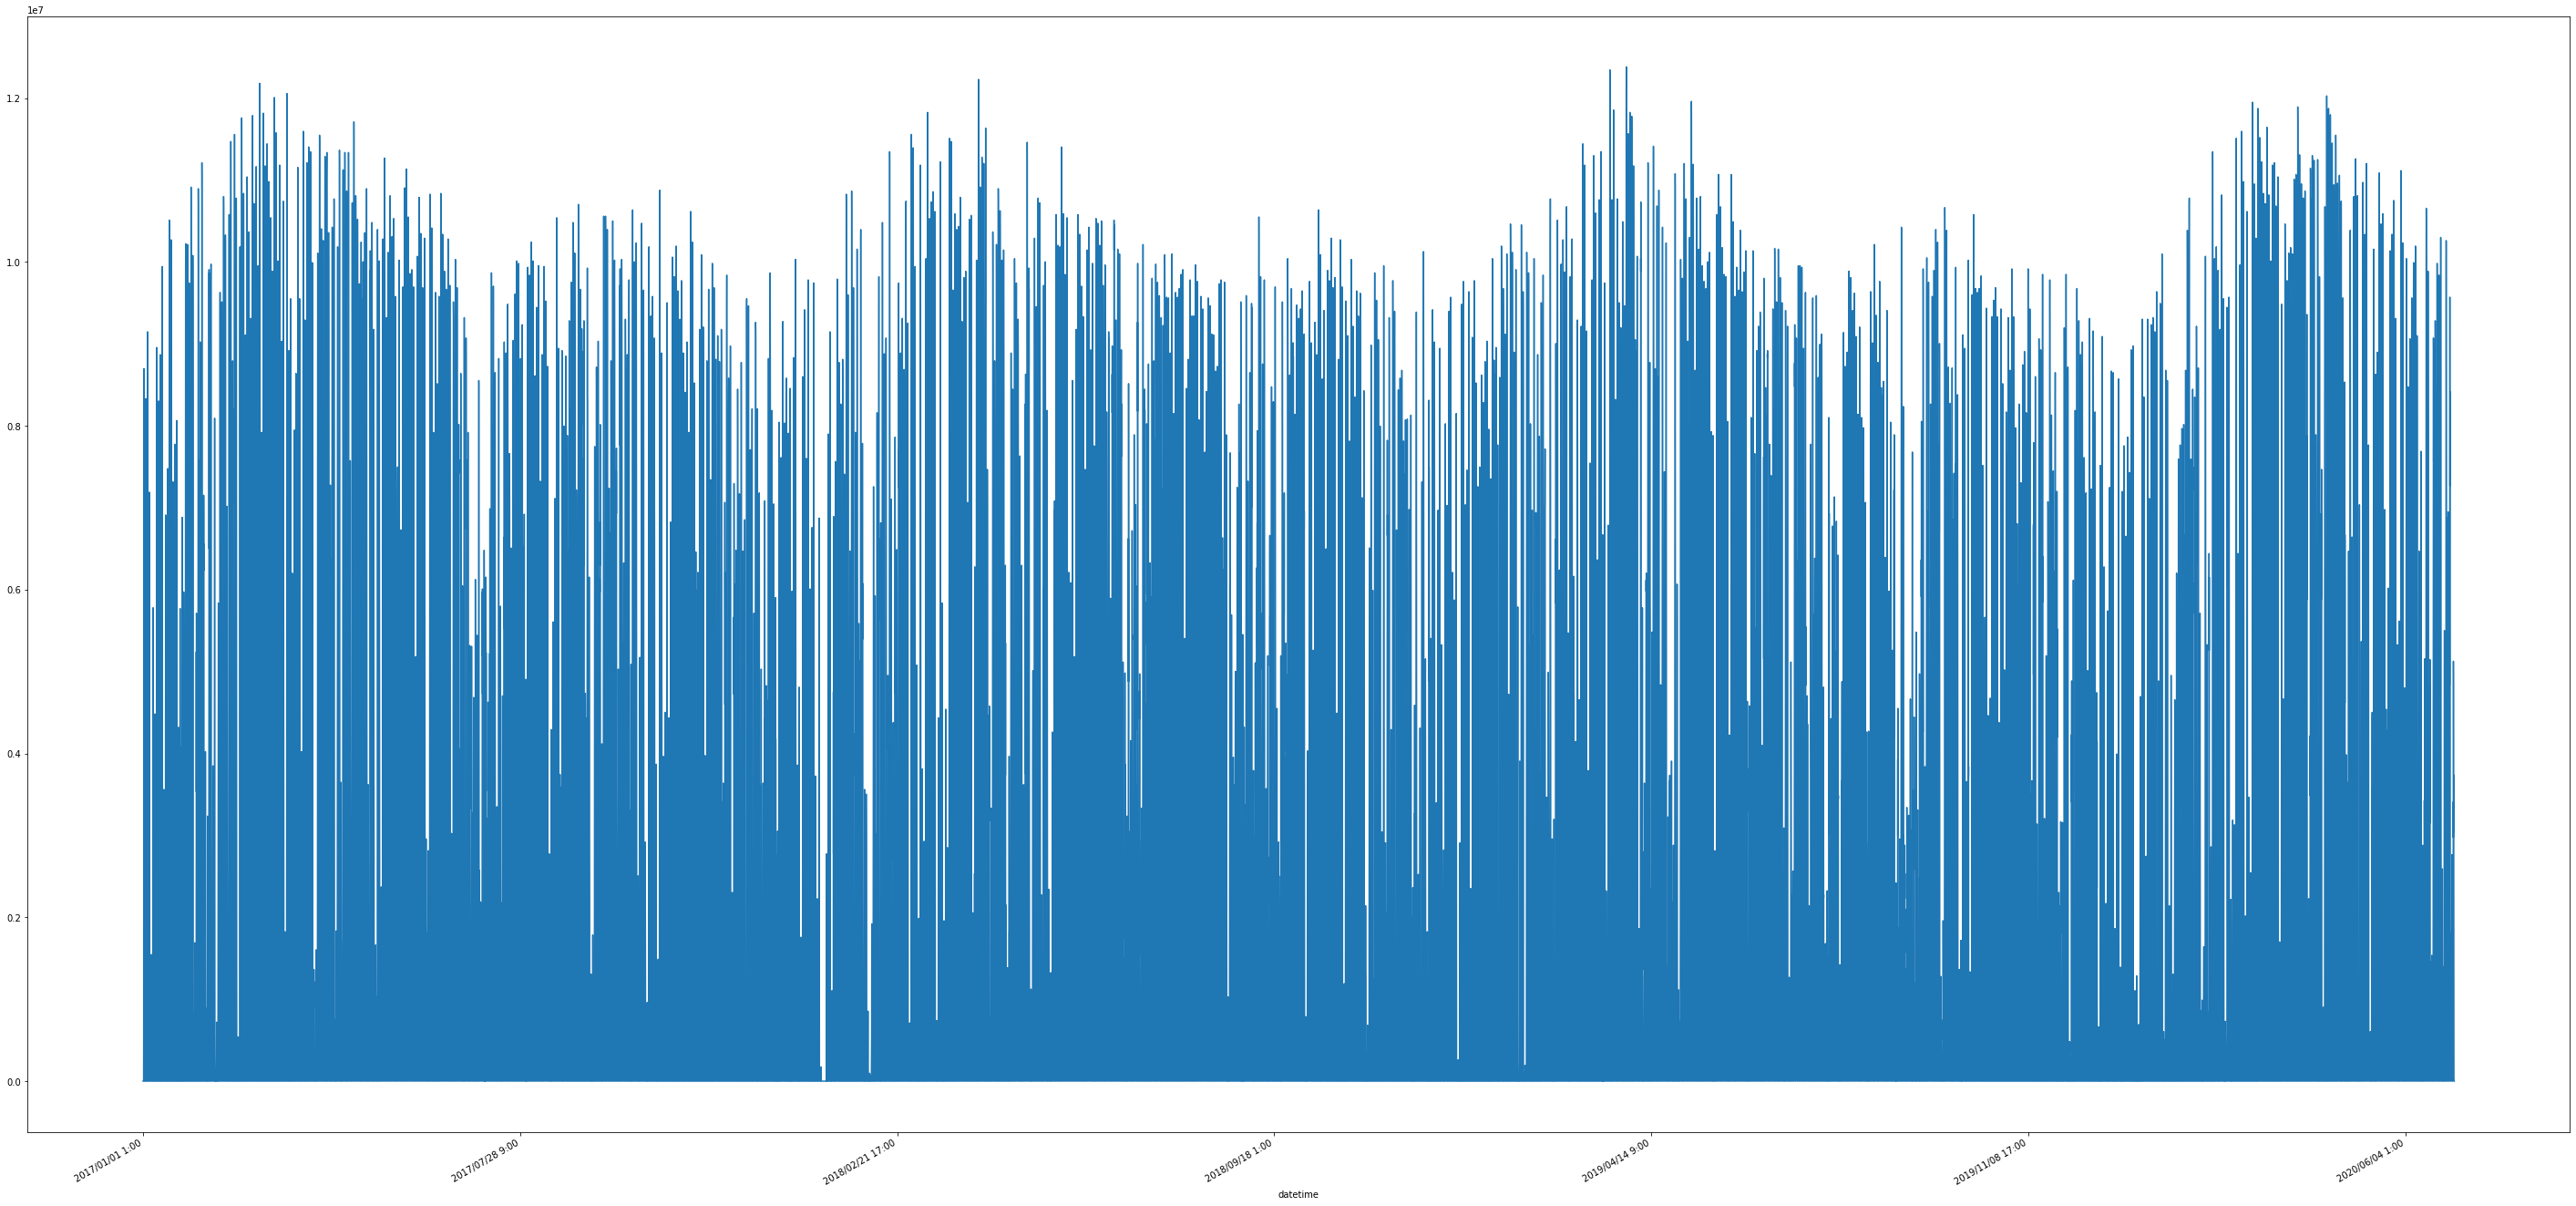

In [20]:
uni_data.plot(subplots=True, figsize=(50,25))

In [44]:
uni_data = uni_data.values
uni_train_mean = uni_data[:train_size].mean(axis=0)
uni_train_std = uni_data[:train_size].std(axis=0)
uni_data = (uni_data - uni_train_mean) / uni_train_std


(30648,)


In [48]:
past_history = 720
future_target = 24
STEP = 1

x_train_uni, y_train_uni = multivariate_data(uni_data, uni_data[:], 0, 
                                             train_size, past_history, 
                                             future_target, STEP)
x_train_uni = x_train_uni.reshape(-1, 720, 1)
y_train_uni = y_train_uni.reshape(-1, 24, 1)

x_val_uni, y_val_uni = multivariate_data(uni_data, uni_data[:], train_size, 
                                         None, past_history, future_target, STEP)

x_val_uni = x_val_uni.reshape(-1, 720, 1)
y_val_uni = y_val_uni.reshape(-1, 24, 1)
print(x_train_uni.shape)

(20733, 720, 1)


In [49]:
batch_size = 64
buffer_size = 10000

train_data_uni = tf.data.Dataset.from_tensor_slices((x_train_uni, y_train_uni))
train_data_uni = train_data_uni.cache().shuffle(buffer_size).batch(batch_size).repeat()

val_data_uni = tf.data.Dataset.from_tensor_slices((x_val_uni, y_val_uni))
val_data_uni = val_data_uni.batch(batch_size).repeat()

In [54]:
with tf.device('/device:GPU:0'):
    single_step_model = tf.keras.models.Sequential()
    single_step_model.add(tf.keras.layers.LSTM(32, return_sequences=True, 
                                              input_shape=(x_train_uni.shape[-2:])))
    single_step_model.add(tf.keras.layers.LSTM(16))
    single_step_model.add(tf.keras.layers.Dense(24))

    single_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(clipvalue=1.0), loss='mae')
    
    callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)

In [55]:
for x, y in val_data_uni.take(1):
    print(single_step_model.predict(x).shape)

(64, 24)


In [57]:
evaluation_interval = 10

single_step_history = single_step_model.fit(train_data_uni, epochs=300,
                                            steps_per_epoch=evaluation_interval,
                                            validation_data=val_data_uni, 
                                            validation_steps=50,
                                            callbacks=[callback])

Epoch 1/300
10/10 [==============================] - 2s 197ms/step - loss: 0.7971 - val_loss: 0.7057
Epoch 2/300
10/10 [==============================] - 1s 141ms/step - loss: 0.7133 - val_loss: 0.6218
Epoch 3/300
10/10 [==============================] - 1s 142ms/step - loss: 0.6444 - val_loss: 0.5567
Epoch 4/300
10/10 [==============================] - 1s 141ms/step - loss: 0.5978 - val_loss: 0.5213
Epoch 5/300
10/10 [==============================] - 1s 142ms/step - loss: 0.5669 - val_loss: 0.4962
Epoch 6/300
10/10 [==============================] - 1s 143ms/step - loss: 0.5322 - val_loss: 0.4873
Epoch 7/300
10/10 [==============================] - 1s 141ms/step - loss: 0.5184 - val_loss: 0.4616
Epoch 8/300
10/10 [==============================] - 1s 143ms/step - loss: 0.5059 - val_loss: 0.4489
Epoch 9/300
10/10 [==============================] - 1s 141ms/step - loss: 0.4874 - val_loss: 0.4399
Epoch 10/300
10/10 [==============================] - 1s 142ms/step - loss: 0.4677 - val_lo

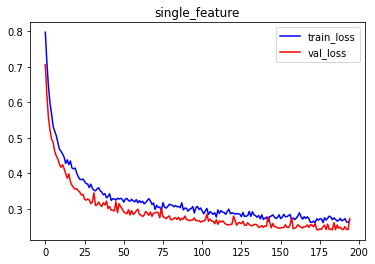

In [58]:
plot_train_history(single_step_history, 'single_feature')

(720, 6) (64, 24) (64, 24)


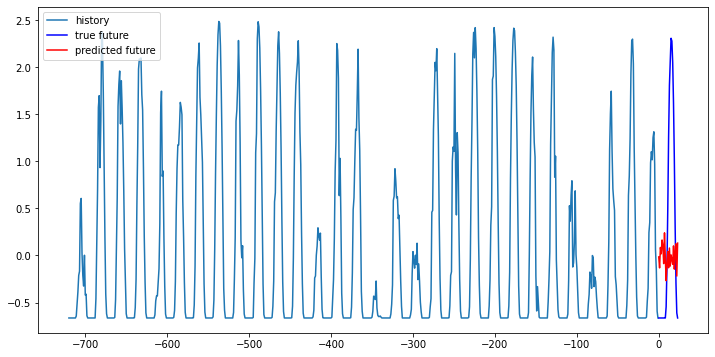

(720, 6) (64, 24) (64, 24)


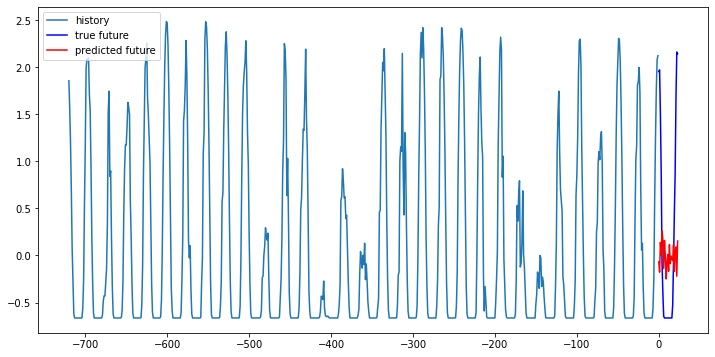

(720, 6) (64, 24) (64, 24)


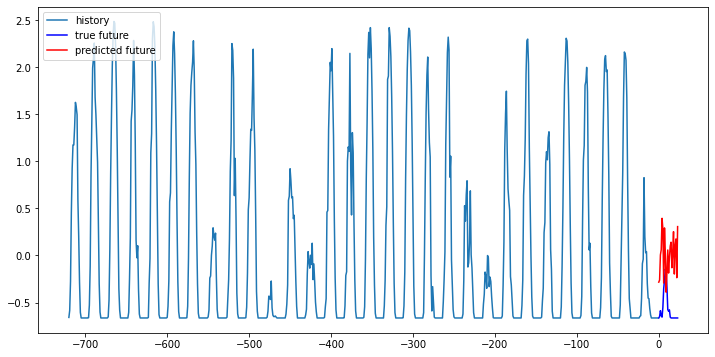

(720, 6) (64, 24) (64, 24)


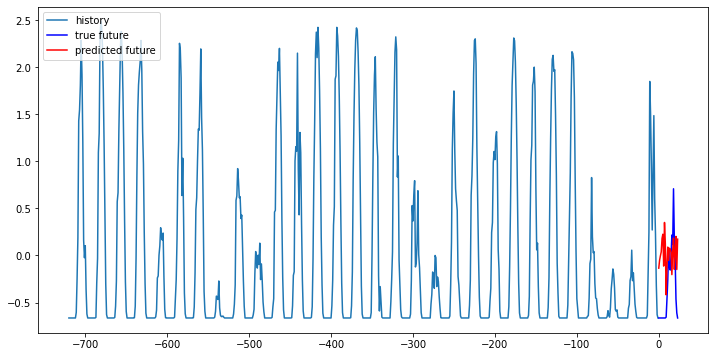

(720, 6) (64, 24) (64, 24)


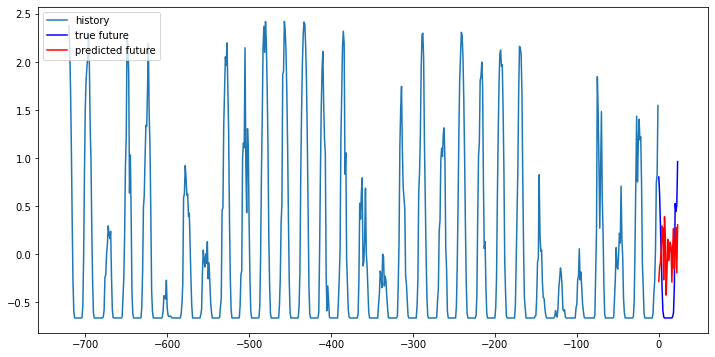

(720, 6) (64, 24) (64, 24)


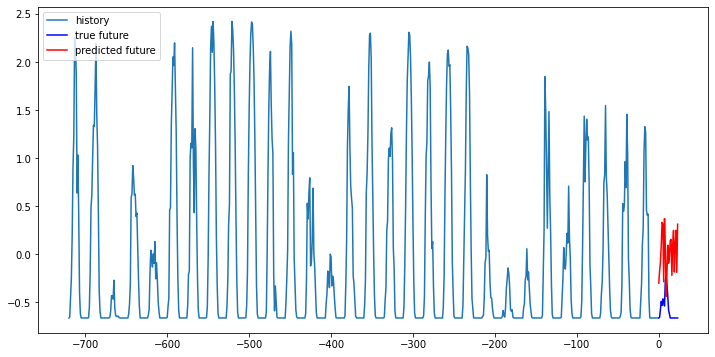

(720, 6) (64, 24) (64, 24)


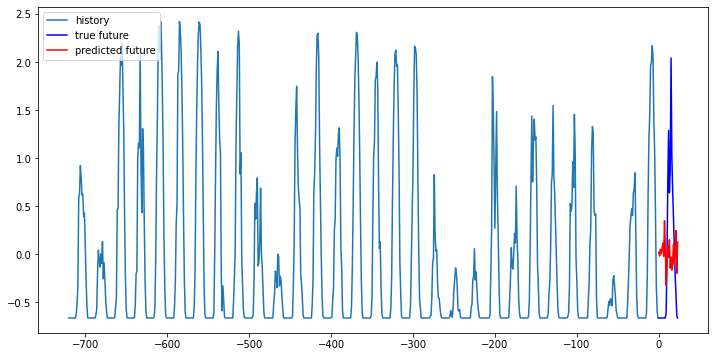

In [59]:
for x, y in val_data_multi.take(7):
    print(x[0].shape, y.shape, multi_step_model.predict(x).shape)
    multi_step_plot(x[0].numpy(), y[0].numpy(), multi_step_model.predict(x)[0])

In [33]:
past_history = 240
future_target = 24
step = 6

dataset = origin_data.values
data_mean = dataset[:train_size].mean(axis=0)
data_std = dataset[:train_size].std(axis=0)
dataset = (dataset-data_mean)/data_std

x_train_multi, y_train_multi = multivariate_data(dataset, dataset[:], 0, 
                                                 train_size, past_history, 
                                                 future_target, step)
x_train_multi = x_train_multi.reshape(-1, 40, 1)
y_train_multi = y_train_multi.reshape(-1, 24, 1)

x_val_multi, y_val_multi = multivariate_data(dataset, dataset[:], train_size, 
                                             None, past_history, future_target, step)
x_val_multi = x_val_multi.reshape(-1, 40, 1)
y_val_multi = y_val_multi.reshape(-1, 24, 1)
print(x_train_multi.shape, y_train_multi.shape, x_val_multi.shape, y_val_multi.shape)

NameError: ignored

In [ ]:
train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))
train_data_multi = train_data_multi.cache().shuffle(buffer_size).batch(batch_size).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_data_multi = val_data_multi.batch(batch_size).repeat()

In [ ]:
def multi_step_plot(history, true_future, prediction):
    plt.figure(figsize=(12, 6))
    num_in = create_time_steps(len(history))
    num_out = len(true_future)

    plt.plot(num_in, np.array(history[:]), label='history')
    plt.plot(np.arange(num_out)/step, np.array(true_future), 'b-', label='true future')
    if prediction.any():
        plt.plot(np.arange(num_out)/step, np.array(prediction), 'r-', label='predicted future')
    plt.legend(loc='upper left')
    plt.show()

In [ ]:
for x, y in val_data_multi.take(1):
    print(multi_step_model.predict(x).shape)

(256, 24)


In [ ]:
with tf.device('/device:GPU:0'):
    multi_step_model = tf.keras.models.Sequential()
    multi_step_model.add(tf.keras.layers.LSTM(32, return_sequences=True, input_shape=(40, 1)))
    multi_step_model.add(tf.keras.layers.LSTM(16, recurrent_activation='sigmoid'))
    multi_step_model.add(tf.keras.layers.Dense(24))

    multi_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(clipvalue=1.0), loss='mae')

In [ ]:
multi_step_history = multi_step_model.fit(train_data_multi, epochs=15,
                                          steps_per_epoch=evaluation_interval,
                                          validation_data=val_data_multi,
                                          validation_steps=50)

Epoch 1/15
200/200 [==============================] - 2s 11ms/step - loss: 0.7976 - val_loss: 0.7579
Epoch 2/15
200/200 [==============================] - 2s 8ms/step - loss: 0.7364 - val_loss: 0.6136
Epoch 3/15
200/200 [==============================] - 2s 8ms/step - loss: 0.5782 - val_loss: 0.4649
Epoch 4/15
200/200 [==============================] - 2s 8ms/step - loss: 0.4652 - val_loss: 0.4100
Epoch 5/15
200/200 [==============================] - 2s 9ms/step - loss: 0.4380 - val_loss: 0.4007
Epoch 6/15
200/200 [==============================] - 2s 8ms/step - loss: 0.4286 - val_loss: 0.3873
Epoch 7/15
200/200 [==============================] - 2s 8ms/step - loss: 0.4221 - val_loss: 0.3956
Epoch 8/15
200/200 [==============================] - 2s 8ms/step - loss: 0.4168 - val_loss: 0.3869
Epoch 9/15
200/200 [==============================] - 2s 8ms/step - loss: 0.4121 - val_loss: 0.3845
Epoch 10/15
200/200 [==============================] - 2s 8ms/step - loss: 0.4078 - val_loss: 0.390

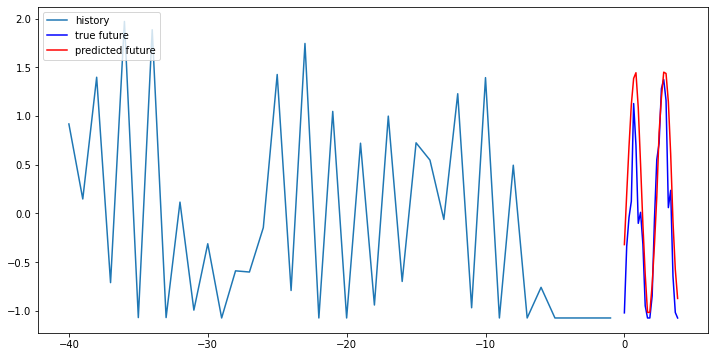

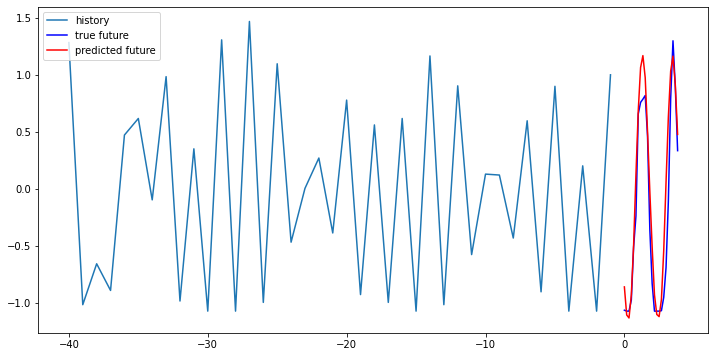

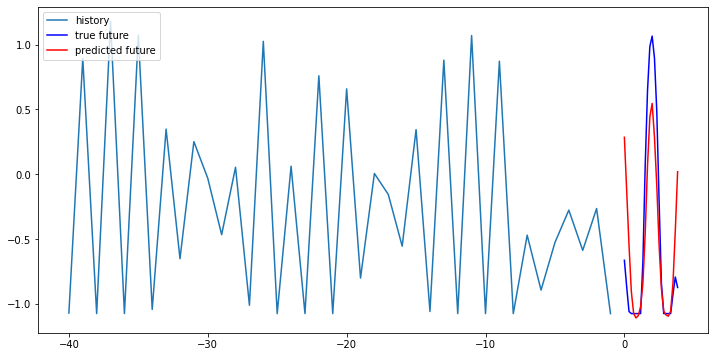

In [ ]:
for x, y in val_data_multi.take(3):
    multi_step_plot(x[0], y[0], multi_step_model.predict(x)[0])